   # 3 keras. LSTM и ARIMA. Dataset - covid19 India.

In [19]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
from time import time
import matplotlib.ticker as tkr

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn import metrics

In [2]:
data = pd.read_csv("case_time_series.csv")[::-1]

Cтатистика зараженных ковид в Индии весной (с февраля по 1 мая).


In [3]:
data.head()

,Date,Daily_Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
92,01-May,2391,37257,962,10021,69,1223
91,30-Apr,1801,34866,630,9059,75,1154
90,29-Apr,1705,33065,690,8429,71,1079
89,28-Apr,1902,31360,636,7739,69,1008
88,27-Apr,1568,29458,580,7103,58,939


In [4]:
#сортировка данных
data.sort_index(inplace=True)

In [5]:
data.shape

(93, 7)

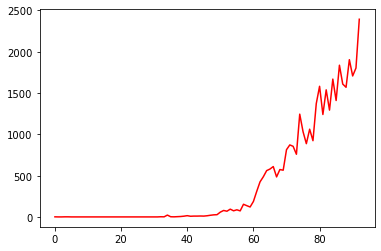

In [6]:
#построим график подтвержденных ковид19 в день
plt.plot(data.Daily_Confirmed, color='r')

Резкий рост на 90-е дни (конец апреля), что в целом происходило в мире.

## Подготовим данные для модели

In [7]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [8]:
dataset = np.array(data.Daily_Confirmed)

In [9]:
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [27]:
# Определим размеры тренировочной и тестовой выборки
train_size = int(len(dataset) * 0.6)
test_size = len(dataset) - train_size

In [28]:
# делим данные на тренировочные и тестовые
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [29]:
look_back = 31

In [30]:
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [31]:
# Для tensorflow нужна следующая размерность [количество выборок, количество дней в окне, количество признаков]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## LSTM

In [44]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from math import sqrt
import math

Строим модель, используя LSTM

In [ ]:
lstm_model = Sequential () 
lstm_model.add (LSTM (200, activation='relu',  input_shape=(X_train.shape[1], X_train.shape[2]))) 

lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile (optimizer = 'adam', loss = 'mse') 


history = lstm_model.fit(X_train, Y_train, epochs=25, batch_size=5, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)


lstm_model.summary ()

### Прогноз

In [37]:
train_predict = lstm_model.predict(X_train)
test_predict = lstm_model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

In [46]:
# качество модели учебном и на тестовом наборах данных
train_score = math.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(Y_test[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 13.18 RMSE
Test Score: 1036.42 RMSE


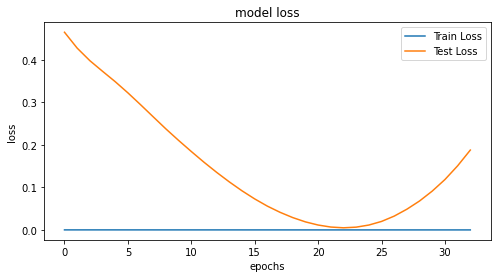

In [48]:
# Выведем функцию ошибок от количества итераций обучения модели

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

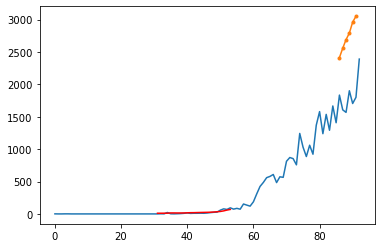

In [64]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(dataset)-1, :] = test_predict
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot, 'r', label="prediction")
plt.plot(testPredictPlot, marker='.', label="actual")
plt.show()


## ARIMA

In [65]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error